In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plot import plot_martingale_paths
from utils import exponential_tilting_indices, split_and_shift_dataset0, mean_func_synthetic_v3, get_1dim_synthetic_v3_data




In [88]:
def plot_wctm_and_xctm_paths(martingales_0_means_dict, x_martingales_0_means_dict, \
                             martingales_0_stderr_dict, x_martingales_0_stderr_dict,\
                             ax, r_idx, c_idx, title_size=12, label_size=12, legend_loc="upper left",\
                             title='Adapting to benign covariate shift...'):

    
    xlabel="Test (Deployment) Datapoint Index $t$"
#     x_label_size=y_label_size=20

    methods = ['fixed_cal_dyn']
    paths_0_dicts_all = [x_martingales_0_means_dict, martingales_0_means_dict]
    paths_0_stderr_dicts_all = [x_martingales_0_stderr_dict, martingales_0_stderr_dict]

    metric_names = ['X-CTM', 'WCTM']
    metric_purposes = {'WCTM' : 'Alarm Criterion', 'X-CTM': 'Adapt Criterion'}
    # stat_formal = {'Martingale' : '($M_t / M_0$)'}

#     plt.figure(figsize=(10, 8))

    colors = {'WCTM' : 'C0', 'X-CTM': 'C7'}

    for p_i, paths_0_dict in enumerate(paths_0_dicts_all):
        paths_0_stderr_dict = paths_0_stderr_dicts_all[p_i]
        metric_name = metric_names[p_i]
        print("plotting ", metric_name)
    #     stat_validity = stat_validities[statistic_name]
        metric_purpose = metric_purposes[metric_name]



        # Plot dataset0 group with dashed lines
        for m_i, method in enumerate(methods):


            for i, path in enumerate(paths_0_dict[method]):
                martingale_stderrs = np.array(paths_0_stderr_dict[method][i])

                ax[r_idx, c_idx].plot(path, label=f'{metric_names[p_i]} ({metric_purposes[metric_name]})', linestyle='-', color=colors[metric_name], linewidth=2)
                ax[r_idx, c_idx].fill_between(np.arange(len(path)), \
                                 (path.to_numpy()-martingale_stderrs).flatten(), \
                                 (path.to_numpy()+martingale_stderrs).flatten(), alpha=0.5, color=colors[metric_name])

        if metric_name == 'WCTM':
            ax[r_idx, c_idx].axhline(y=10**2, color='darkblue', linestyle='--', label='WCTM Alarm Threshold', linewidth=3)

        elif metric_name == 'X-CTM':
            ax[r_idx, c_idx].axhline(y=10, color='gray', linestyle=':', label='X-CTM Adapt Threshold', linewidth=2)
    #         # Plot dataset1 group with solid lines
    #         for i, path in enumerate(dataset1_paths_dict[method]):
    #             plt.plot(path, label=f'Red Wine Fold {i+1}', linestyle='-', color=f'C{i+3}')

        # Add vertical line at the change point
        # plt.axvline(x=change_point_index-num_test_unshifted, color='gray', linestyle=':', linewidth=3, label='Deployment time')
    ax[r_idx, c_idx].axvline(x=change_point_index, color='k', linestyle='solid', linewidth=5, label='Changepoint')
    # plt.axhline(y=10**2, color='red', linestyle='--', label='Alarm threshold', linewidth=3)
    # plt.axhline(y=10, color='gray', linestyle=':', label='Adaptation threshold', linewidth=2)

    ax[r_idx, c_idx].set_yscale('log')  # Use logarithmic scale for the y-axis
    ax[r_idx, c_idx].set_xlabel(xlabel, fontsize=label_size)
    ax[r_idx, c_idx].set_ylabel(fr'Mean Martingale Values', fontsize=label_size)
    ax[r_idx, c_idx].set_title(title, fontsize=title_size)
    ax[r_idx, c_idx].set_ylim([0.1, 10**7])
    ax[r_idx, c_idx].legend(loc=legend_loc)
    
#     if c_idx == 0:
#         ax[r_idx, c_idx].text(-130, 10**9/4, '(d)', horizontalalignment='center', verticalalignment='center', fontsize=title_size)
#         ax[0,2].arrow(x=35, y=7.0, dx=-9, dy=-1.25,head_length=6, head_width=1, color='black')
        
#     ax[r_idx, c_idx].text(report_text)



In [89]:


## Plotting covariate shift results


results_benign_cov = pd.read_csv('../results/2025-01-29_1dim_synthetic_v3-NN-covariate-c_bias-0.025-label0-win50-csabs-nseeds5-Wfixed_cal_dyn_none-numTUn500-test0Size0.33333-initCalFalse-schboth-pHold0.75_v5.csv')
results_harmful_cov = pd.read_csv('../results/2025-01-29_1dim_synthetic_v3-NN-covariate-c_bias0.75-label0-win50-csabs-nseeds5-Wfixed_cal_dyn_none-numTUn500-test0Size0.33333-initCalFalse-schboth-pHold0.75_v5.csv')
results_harmful_concept = pd.read_csv('../results/2025-01-29_1dim_synthetic_v3-NN-label-c_bias0.0-label0.0033-win50-csabs-nseeds5-Wfixed_cal_dyn_none-numTUn500-test0Size0.33333-initCalFalse-schboth-pHold0.75_v5.csv')
    
martingales_0_means_dict_all_shifts = []
x_martingales_0_means_dict_all_shifts = []
martingales_0_stderr_dict_all_shifts = []
x_martingales_0_stderr_dict_all_shifts = []

for results in [results_benign_cov, results_harmful_cov, results_harmful_concept]:
    test0_size = 0.33333
    num_folds = 1
    methods = ['fixed_cal_dyn', 'none']
    methods_all = "_".join(methods)
    n_seeds=5
    errs_window=50
    dataset1=None
    dataset1_name=None
    dataset0_shift_type='covariate'
    label_shift=None
    plot_errors=False
    cs_type='abs'
    muh_fun_name='NN'
    training_schedule='both'
    num_test_unshifted = 500
    xctm_thresh = 10
    wctm_thresh = 10**2
    # sr_ctm_thresh = 10**4
    max_path_length = 700 ## maximum length of path to plot

    n_1dim_synthetic_v3 = 20000

    dataset0_name = '1dim_synthetic_v3'
    cov_shift_bias = -0.01

    num_obs = max(results['obs_idx'])+1

    n_dataset = eval('n_'+dataset0_name)
    print("n_dataset : ", n_dataset)
    print("num_test_unshifted : ", num_test_unshifted)

    # change_point_index = n_dataset*(1-test0_size)/max(2,num_folds)+num_test_unshifted
    change_point_index = num_test_unshifted

    setting = '{}-{}-{}-shift_bias{}-label_shift{}-err_win{}-cs_type{}-nseeds{}-W{}-numTestUnshifted{}-test0Size{}'.format(
        dataset0_name,
        muh_fun_name,
        dataset0_shift_type,
        cov_shift_bias,
        label_shift,
        errs_window,
        cs_type,
        n_seeds,
        methods_all,
        num_test_unshifted,
        test0_size
    )



    ## Preparation for plotting
    sigmas_0_means_dict, sigmas_1_means_dict = {}, {}
    sigmas_0_stderr_dict, sigmas_1_stderr_dict = {}, {}
    martingales_0_means_dict, martingales_1_means_dict = {}, {}
    martingales_0_stderr_dict, martingales_1_stderr_dict = {}, {}
    x_sigmas_0_means_dict, x_sigmas_1_means_dict = {}, {}
    x_sigmas_0_stderr_dict, x_sigmas_1_stderr_dict = {}, {}
    x_martingales_0_means_dict, x_martingales_1_means_dict = {}, {}
    x_martingales_0_stderr_dict, x_martingales_1_stderr_dict = {}, {}

    errors_0_means_dict, errors_1_means_dict = {}, {}
    errors_0_stderr_dict, errors_1_stderr_dict = {}, {}
    coverage_0_means_dict = {}
    coverage_0_stderr_dict = {}
    widths_0_medians_dict = {}
    widths_0_lower_q_dict = {}
    widths_0_upper_q_dict = {}
    pvals_0_means_dict = {}
    pvals_0_stderr_dict = {}
    p_vals_pre_change_dict = {}
    p_vals_post_change_dict = {}



    for method in methods:

        ## Compute average and stderr values for plotting
        print(method)
        paths_all = results[results['method']==method]


        sigmas_0_means, sigmas_1_means = [], []
        sigmas_0_stderr, sigmas_1_stderr = [], []
        martingales_0_means, martingales_1_means = [], []
        martingales_0_stderr, martingales_1_stderr = [], []

        x_sigmas_0_means, x_sigmas_1_means = [], []
        x_sigmas_0_stderr, x_sigmas_1_stderr = [], []
        x_martingales_0_means, x_martingales_1_means = [], []
        x_martingales_0_stderr, x_martingales_1_stderr = [], []


        errors_0_means, errors_1_means = [], []
        errors_0_stderr, errors_1_stderr = [], []
        coverage_0_means = []
        coverage_0_stderr = []
        widths_0_medians = []
        widths_0_lower_q = []
        widths_0_upper_q = []
        pvals_0_means = []
        pvals_0_stderr = []

        ## For each fold/separate martingale path
        for i in range(0, num_folds):
            ## Compute average martingale values over trials
            sigmas_0_means.append(paths_all[['sigmas_0_'+str(i), 'obs_idx']].groupby('obs_idx').mean()[:max_path_length])
            sigmas_0_stderr.append(paths_all[['sigmas_0_'+str(i), 'obs_idx']].groupby('obs_idx').std()[:max_path_length] / np.sqrt(n_seeds))

            martingales_0_means.append(paths_all[['martingales_0_'+str(i), 'obs_idx']].groupby('obs_idx').mean()[:max_path_length])
            martingales_0_stderr.append(paths_all[['martingales_0_'+str(i), 'obs_idx']].groupby('obs_idx').std()[:max_path_length] / np.sqrt(n_seeds))

            x_sigmas_0_means.append(paths_all[['xctm_sr_paths_0_'+str(i), 'obs_idx']].groupby('obs_idx').mean()[:max_path_length])
            x_sigmas_0_stderr.append(paths_all[['xctm_sr_paths_0_'+str(i), 'obs_idx']].groupby('obs_idx').std()[:max_path_length] / np.sqrt(n_seeds))

            x_martingales_0_means.append(paths_all[['xctm_paths_0_'+str(i), 'obs_idx']].groupby('obs_idx').mean()[:max_path_length])
            x_martingales_0_stderr.append(paths_all[['xctm_paths_0_'+str(i), 'obs_idx']].groupby('obs_idx').std()[:max_path_length] / np.sqrt(n_seeds))

            ## Compute average and stderr absolute score (residual) values over window, trials
            errors_0_means_fold = []
            errors_0_stderr_fold = []
            coverage_0_means_fold = []
            coverage_0_stderr_fold = []
            widths_0_medians_fold = []
            widths_0_lower_q_fold = []
            widths_0_upper_q_fold = []
            pvals_0_means_fold = []
            pvals_0_stderr_fold = []

            last_index = int(min(num_obs, max_path_length) / errs_window)
            for j in range(0, last_index+1):
                ## Subset dataframe by window
                paths_all_sub = paths_all[paths_all['obs_idx'].isin(np.arange(j*errs_window,(j+1)*errs_window))]

                ## Averages and stderrs for that window
                errors_0_means_fold.append(paths_all_sub['errors_0_'+str(i)].mean())
                errors_0_stderr_fold.append(paths_all_sub['errors_0_'+str(i)].std() / np.sqrt(n_seeds*errs_window))

                ## Coverages for window
                coverage_0_means_fold.append(paths_all_sub['coverage_0_'+str(i)].mean())
                coverage_0_stderr_fold.append(paths_all_sub['coverage_0_'+str(i)].std() / np.sqrt(n_seeds*errs_window))

                ## Widths for window
                wid_med = paths_all_sub['widths_0_'+str(i)].median()
                widths_0_medians_fold.append(wid_med)
                widths_0_lower_q_fold.append(paths_all_sub['widths_0_'+str(i)].quantile(0.25))
                widths_0_upper_q_fold.append(paths_all_sub['widths_0_'+str(i)].quantile(0.75))

                ## P values for window
                pvals_0_means_fold.append(paths_all_sub['pvals_0_'+str(i)].mean())
                pvals_0_stderr_fold.append(paths_all_sub['pvals_0_'+str(i)].std() / np.sqrt(n_seeds*errs_window))


            ## Averages and stderrs for that fold
            errors_0_means.append(errors_0_means_fold)
            errors_0_stderr.append(errors_0_stderr_fold)

            ## Average coverages for fold
            coverage_0_means.append(coverage_0_means_fold)
            coverage_0_stderr.append(coverage_0_stderr_fold)

            ## Median widths for fold
            widths_0_medians.append(widths_0_medians_fold)
            widths_0_lower_q.append(widths_0_lower_q_fold)
            widths_0_upper_q.append(widths_0_upper_q_fold)

            ## Average pvals for fold
            pvals_0_means.append(pvals_0_means_fold)
            pvals_0_stderr.append(pvals_0_stderr_fold)




        sigmas_0_means_dict[method], sigmas_1_means_dict[method] = sigmas_0_means, sigmas_1_means
        sigmas_0_stderr_dict[method], sigmas_1_stderr_dict[method] = sigmas_0_stderr, sigmas_1_stderr
        martingales_0_means_dict[method], martingales_1_means_dict[method] = martingales_0_means, martingales_1_means
        martingales_0_stderr_dict[method], martingales_1_stderr_dict[method] = martingales_0_stderr, martingales_1_stderr

        x_sigmas_0_means_dict[method], x_sigmas_1_means_dict[method] = x_sigmas_0_means, x_sigmas_1_means
        x_sigmas_0_stderr_dict[method], x_sigmas_1_stderr_dict[method] = x_sigmas_0_stderr, x_sigmas_1_stderr
        x_martingales_0_means_dict[method], x_martingales_1_means_dict[method] = x_martingales_0_means, x_martingales_1_means
        x_martingales_0_stderr_dict[method], x_martingales_1_stderr_dict[method] = x_martingales_0_stderr, x_martingales_1_stderr


        errors_0_means_dict[method], errors_1_means_dict[method] = errors_0_means, errors_1_means
        errors_0_stderr_dict[method], errors_1_stderr_dict[method] = errors_0_stderr, errors_1_stderr
        coverage_0_means_dict[method] = coverage_0_means
        coverage_0_stderr_dict[method] = coverage_0_stderr
        pvals_0_means_dict[method] = pvals_0_means
        pvals_0_stderr_dict[method] = pvals_0_stderr
        widths_0_medians_dict[method] = widths_0_medians
        widths_0_lower_q_dict[method] = widths_0_lower_q
        widths_0_upper_q_dict[method] = widths_0_upper_q



        ## Saving p-values together for histograms
        paths_pre_change = paths_all[paths_all['obs_idx'] < change_point_index]
        paths_post_change = paths_all[paths_all['obs_idx'] >= change_point_index]

        p_vals_pre_change = paths_pre_change['pvals_0_0']
        p_vals_post_change = paths_post_change['pvals_0_0']

        for i in range(1, num_folds):
            p_vals_pre_change = np.concatenate((p_vals_pre_change, paths_pre_change[f'pvals_0_{i}']))
            p_vals_post_change = np.concatenate((p_vals_post_change, paths_post_change[f'pvals_0_{i}']))

        p_vals_pre_change_dict[method] = p_vals_pre_change
        p_vals_post_change_dict[method] = p_vals_post_change



    martingales_0_means_dict_all_shifts.append(martingales_0_means_dict)
    x_martingales_0_means_dict_all_shifts.append(x_martingales_0_means_dict)
    martingales_0_stderr_dict_all_shifts.append(martingales_0_stderr_dict)
    x_martingales_0_stderr_dict_all_shifts.append(x_martingales_0_stderr_dict)
    

n_dataset :  20000
num_test_unshifted :  500
fixed_cal_dyn
none
n_dataset :  20000
num_test_unshifted :  500
fixed_cal_dyn
none
n_dataset :  20000
num_test_unshifted :  500
fixed_cal_dyn
none


1dim_synthetic_v3
14
plotting  X-CTM
plotting  WCTM
plotting  X-CTM
plotting  WCTM
plotting  X-CTM
plotting  WCTM


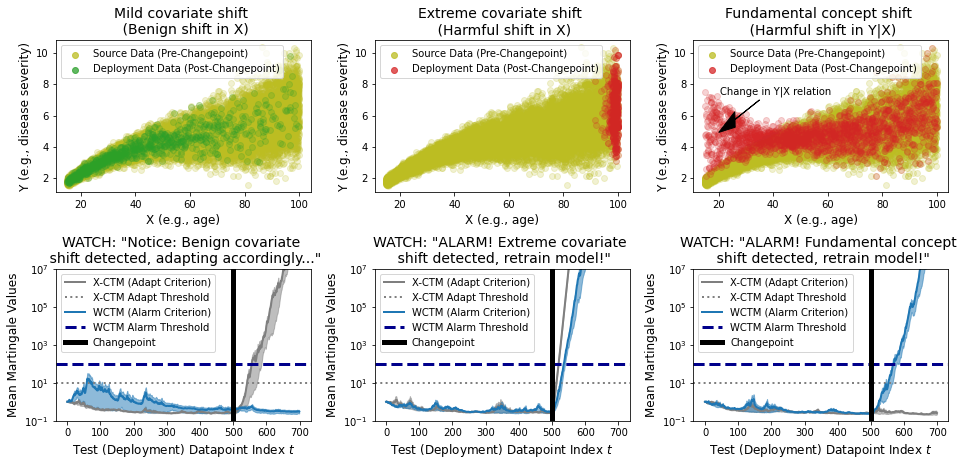

In [90]:

simulated_data = get_1dim_synthetic_v3_data()
simulated_data


fig, ax = plt.subplots(2, 3,figsize=(16, 7))

title_size = 14
x_axis_size=12
y_axis_size=12
plt.subplots_adjust(wspace=0.25, hspace=0.5)


# ## Benign shift
ax[0,0].scatter(simulated_data['X'], simulated_data['Y'], color='C8', alpha=0.2, label='Source Data (Pre-Changepoint)')

biased_indices = exponential_tilting_indices(simulated_data['X'], simulated_data['X'], dataset='1dim_synthetic_v3', bias=-0.025, frac=0.05)

ax[0,0].scatter(simulated_data['X'][biased_indices], simulated_data['Y'][biased_indices], alpha=0.2, label='Deployment Data (Post-Changepoint)', color='C2')
leg = ax[0,0].legend()
for lh in leg.legendHandles: 
    lh.set_alpha(0.75)
ax[0,0].set_xlabel('X (e.g., age)', fontsize=x_axis_size)
ax[0,0].set_ylabel('Y (e.g., disease severity)', fontsize=y_axis_size)
ax[0,0].set_title('Mild covariate shift \n (Benign shift in X)', fontsize=title_size)
# ax[0,0].text(-4,12.6,'(a)', fontsize=title_size)
    
## Extreme covariate shift
ax[0,1].scatter(simulated_data['X'], simulated_data['Y'], color='C8', alpha=0.2, label='Source Data (Pre-Changepoint)')

biased_indices = exponential_tilting_indices(simulated_data['X'], simulated_data['X'], dataset='1dim_synthetic_v3', bias=0.75, frac=0.025)

ax[0,1].scatter(simulated_data['X'][biased_indices], simulated_data['Y'][biased_indices], alpha=0.2, label='Deployment Data (Post-Changepoint)', color='C3')
leg = ax[0,1].legend()
for lh in leg.legendHandles: 
    lh.set_alpha(0.75)
ax[0,1].set_xlabel('X (e.g., age)', fontsize=x_axis_size)
ax[0,1].set_ylabel('Y (e.g., disease severity)', fontsize=y_axis_size)
ax[0,1].set_title('Extreme covariate shift \n (Harmful shift in X)', fontsize=title_size)
# ax[0,1].text(-4,12.6,'(b)', fontsize=title_size)




## Concept shifts
ax[0,2].scatter(simulated_data['X'], simulated_data['Y'], color='C8', alpha=0.2, label='Source Data (Pre-Changepoint)')

dataset0_train, dataset0_test_0 = split_and_shift_dataset0(simulated_data, dataset0_name='1dim_synthetic_v3', test0_size=0.1, dataset0_shift_type='label', label_uptick=0.0033, num_test_unshifted=0)

ax[0,2].scatter(dataset0_test_0['X'], dataset0_test_0['Y'], alpha=0.2, label='Deployment Data (Post-Changepoint)', color='C3')
leg = ax[0,2].legend()
for lh in leg.legendHandles: 
    lh.set_alpha(0.75)
ax[0,2].text(41, 7.55, 'Change in Y|X relation', horizontalalignment='center', verticalalignment='center')
ax[0,2].arrow(x=35, y=7.0, dx=-9, dy=-1.25,head_length=6, head_width=1, color='black')
ax[0,2].set_xlabel('X (e.g., age)', fontsize=x_axis_size)
ax[0,2].set_ylabel('Y (e.g., disease severity)', fontsize=y_axis_size)
ax[0,2].set_title('Fundamental concept shift \n (Harmful shift in Y|X)', fontsize=title_size)
# ax[0,2].text(-4,12.6,'(c)', fontsize=title_size)


print(title_size)
plot_wctm_and_xctm_paths(martingales_0_means_dict_all_shifts[0], x_martingales_0_means_dict_all_shifts[0], \
                             martingales_0_stderr_dict_all_shifts[0], x_martingales_0_stderr_dict_all_shifts[0],\
                             ax=ax, r_idx=1, c_idx=0, title_size=title_size, label_size=x_axis_size, \
                             title='WATCH: "Notice: Benign covariate \n shift detected, adapting accordingly..."')

plot_wctm_and_xctm_paths(martingales_0_means_dict_all_shifts[1], x_martingales_0_means_dict_all_shifts[1], \
                             martingales_0_stderr_dict_all_shifts[1], x_martingales_0_stderr_dict_all_shifts[1],\
                             ax=ax, r_idx=1, c_idx=1, title_size=title_size, label_size=x_axis_size, \
                             title='WATCH: "ALARM! Extreme covariate \n shift detected, retrain model!"')

plot_wctm_and_xctm_paths(martingales_0_means_dict_all_shifts[2], x_martingales_0_means_dict_all_shifts[2], \
                             martingales_0_stderr_dict_all_shifts[2], x_martingales_0_stderr_dict_all_shifts[2],\
                             ax=ax, r_idx=1, c_idx=2, title_size=title_size, label_size=x_axis_size, \
                             title='WATCH: "ALARM! Fundamental concept \n shift detected, retrain model!"')

plt.savefig('./Figure1_SyntheticData.pdf', bbox_inches='tight')
